# Block Ciphers

In [1]:
from blockciphers import aes_image_encryption, mcs_diffusion, mcs_confusion, RC4
from Crypto.Cipher import AES, ARC4
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np

## Introduction

**Block Ciphers** are symmetric ciphers that split the plaintext in fixed size blocks and encrypt them using the same key. Typically the encryption is made of many **rounds**, all constituted by the same set of simpler transformations, so that the final ciphertext is more secure than the intermediate ones. To guarantee security, some tranformations are linear to provide diffusion and others are non linear to provide confusion. [[1]](#references)

If blocks are encrypted independently one from another, even very performant block ciphers don't provide good security because statistical regularities and patterns of the plaintext may be recognized analyzing the chiphertext (similarly to Substitution Ciphers). For this reason several **Modes of Operations** were proposed, where the current ciphertext block depends not only on the respective plaintext block.

This notebook will focus on **Advanced Encryption Standard (AES)** (and on his predecessor **RC4**), with the objective of seeing how different Modes of Operations work and to assess the level of diffusion and confusion this algorithm is capable to provide. 

## AES

**AES**, originally named *Rijndael*, was firstly proposed in 1998 as a candidate for a NIST challenge that it officially won in 2000. Its main characteristics are:
- fixed block size of 16 bytes.
- key length of 16, 24 or 32 bytes.
- 10, 12 or 14 rounds depending on the key length.

The encryption process is made of two parts:
- Key Schedule: it takes as input the key and produces 16 bytes round keys needed for the encryption. The round keys can be produced while the encryption goes on since they are used in the same order as they are computed.
- Datapath: it is the sequence of rounds the plaintext goes through. Each round is composed by three layers:
    - Linear Mixing Layer: it constitutes the linear transformation providing diffusion. It is divided into two sub-transformations, respectively called *Shift Rows* and *Mixing Columns*.
    - Non Linear Layer or Byte Substitution: it constitutes the non linear transformation providing confusion.
    - Key Addition Layer: it takes as inputs the intermediate ciphertext and the round key and XOR them together.

To decrypt a ciphertext, one need to compute all the inverse transformations and apply them in the opposite order with respet to encryption. The only issue is that all the round keys must be computed before starting with the real decryption since the first to be used is the last to be produced. [[2]](#references)

![AES structure](AES.jpg)

In [2]:
# Open the PNG image
image_path = 'image.png'

# Generate a random 16 bytes key
random_key = np.random.bytes(16)

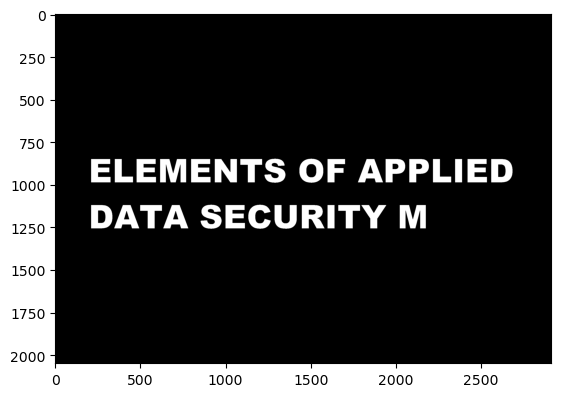

In [3]:
image = imread(image_path).mean(axis=-1)
image = 255 * image.astype(np.uint8)
plt.imshow(image, cmap='gray');

### Electronic Code Book (ECB)

With the **ECB Mode of Operation**, each block is encrypted independently from the others. As it has already been suggested, this method does not provide good security because statistical properties of the plaintext may be found also in the ciphertext.

Looking at the encrypted image below, one can easily recognize the text.

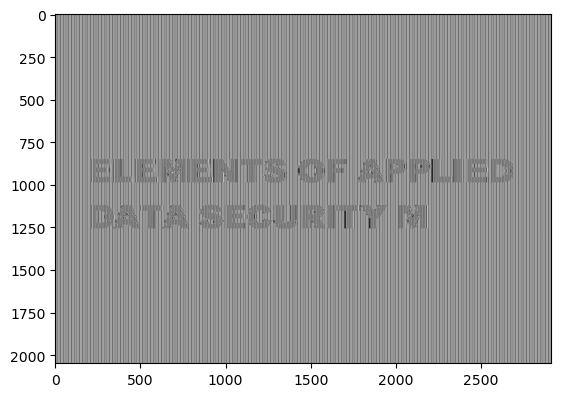

In [4]:
# Instantiate AES with ECB mode of operation
aes_ecb = AES.new(random_key, AES.MODE_ECB)
# Encrypt the image
aes_image_encryption(aes_ecb, 'ECB', image)

### Cipher Block Chaining (CBC)

If one uses **CBC Mode of Operation**, each plaintext block is XORed with the previous ciphertext block before being encrypted: in this way blocks are not independent anymore and statistical regularities of the plaintext can be better hidden. The first block is XORed togehter with an **Initialization Vector (IV)** that is kept secret and usually is a **NONCE (Number Used Once)**.

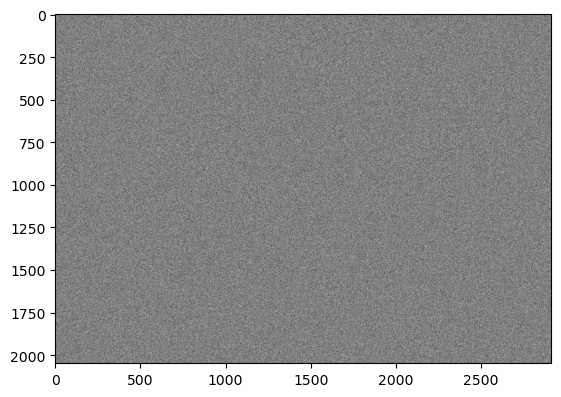

In [5]:
# Instantiate AES with CBC mode of operation
aes_cbc = AES.new(random_key, AES.MODE_CBC)
# Encrypt the image
aes_image_encryption(aes_cbc, 'CBC', image)

### Cipher Feedback (CFB)

In **CFB Mode of Operation**, the block cipher is used as building element for a stream cipher: each keystream block, eventually XORED with the respective plaintext block, is the result of the encryption of the previous ciphertext block. Also in this case the first keystream block is computed starting form an Initialization Vector.

Since blocks are not treated as independent entities, the final ciphertext is much more secure.

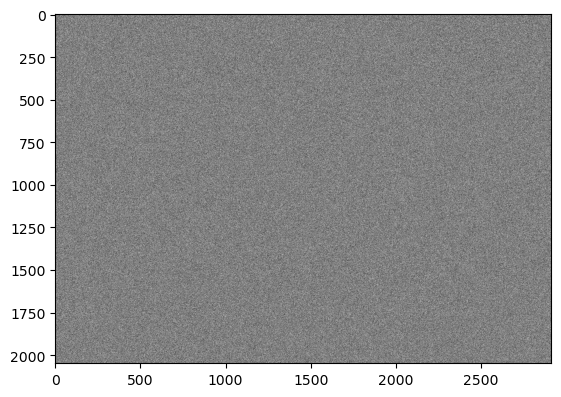

In [6]:
# Instantiate AES with CFB mode of operation
aes_cfb= AES.new(random_key, AES.MODE_CFB)
# Encrypt the image
aes_image_encryption(aes_cfb, 'CFB', image)

### Counter (CTR)

In **CTR Mode of Operation** a stream cipher is built and the keystream blocks are the result of the encryption of particular blocks made of two parts: the first is a NONCE and the second is the output of a counter. Since each plaintext block is encrypted always with a brand new keystream, the ciphertext is secure and no patterns can be detected. In addition, consecutive blocks are not dependent, then both encryption and decryption can be **parallelized**, making this method very efficient.

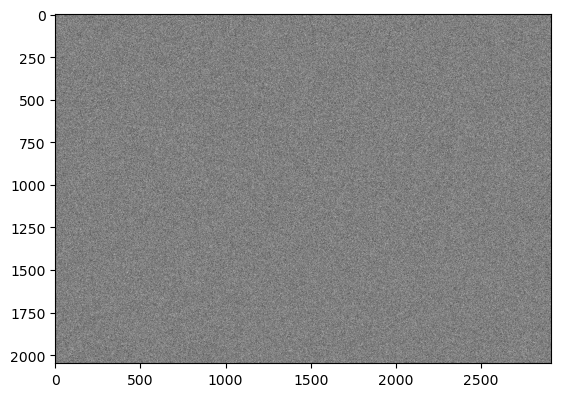

In [7]:
# Instantiate AES with CTR mode of operation
aes_ctr = AES.new(random_key, AES.MODE_CTR)
# Encrypt the image
aes_image_encryption(aes_ctr, 'CTR', image)

## Monte Carlo Simulation

**Monte Carlo Methods** are a series of algorithms that try to gather some information or numerical result by means of **repeated random sampling**. The general proceudre is the following:
- define the input domain .
- draw some random samples in the domain given a certain probability distribution function.
- measure or compute the quantity you are interested in for each sample.
- combine the results. [[3]](#references)

### $\pi$ estimation


A well known application of Monte Carlo simulation is the **estimation of $\pi$**.

Given a square and a circle inscribed in it, the following relation is true:$$\frac{A_{circle}}{A_{square}} = \frac{\pi r^2}{(2r)^2} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4} \Rightarrow \pi = 4\frac{A_{circle}}{A_{square}}$$

The ratio between the two areas can be estimated drawing some uniformly distributed random points inside the square and computing the ratio between the number of points inside the circle (in our case with radius 1) and the total number of samples. The domain can also be reduced to only a quarter of the square since the proportion between the two areas remains the same.

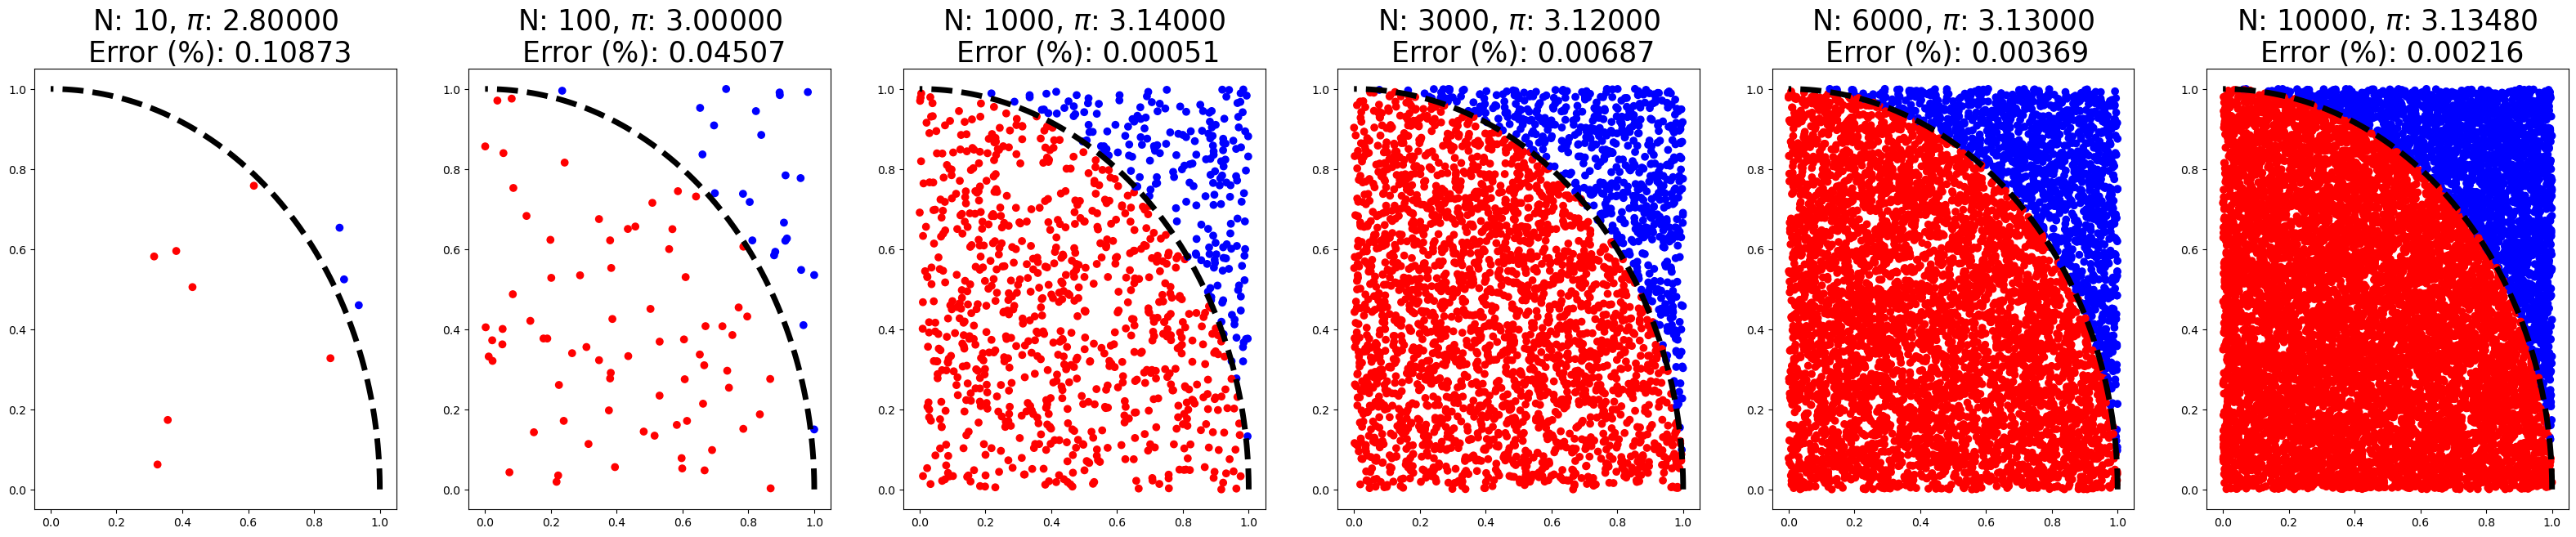

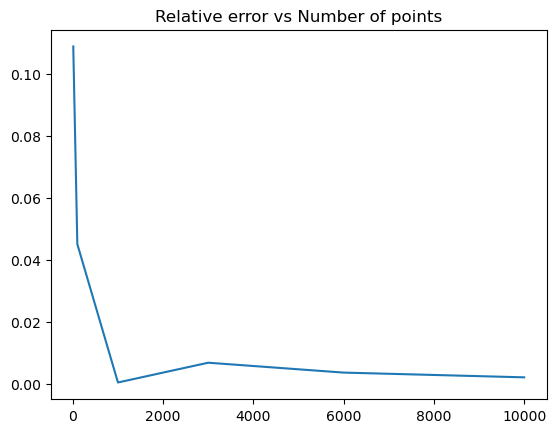

In [18]:
n_points = [10, 100, 1000, 3000, 6000, 10000]

fig1, axs1 = plt.subplots(1, len(n_points), figsize=(40, 7))

# Points to plot the quarter of circle
theta = np.linspace(0, np.pi/2, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)

# Lists containg the pi estimations and the respective relative errors
pi_est = []
err = []
for idx, n in enumerate(n_points):
    # Number of points falling inside the circle
    circle_points = 0
    colors = []
    # Randomly drawn points coordinates
    x_coord = np.random.rand(n)
    y_coord = np.random.rand(n)
    # Counting how many points are inside the circle
    for x, y in zip(x_coord, y_coord):
        if np.linalg.norm((x, y)) <= 1:
            colors.append('red')
            circle_points += 1
        else:
            colors.append('blue')

    # Compute pi estimation and respective relative error       
    pi_est.append(4*circle_points/n)
    err.append(np.abs(pi_est[idx] - np.pi)/np.pi)

    axs1[idx].scatter(x_coord, y_coord, c=colors)
    axs1[idx].plot(x_circle, y_circle, linestyle='--', linewidth=5, color='black')
    axs1[idx].set_title(f'N: {n}, $\\pi$: {pi_est[idx]:.5f}\n Error (%): {err[idx]:.5f}', fontsize = 25)

plt.figure()
plt.plot(n_points, err)
plt.title('Relative error vs Number of points');

Analyzing the results of the experiment, one can notice that the relative error is subject to a very rapid improvement in the fisrt trials and remains practically the same when the number of samples gets higher and higher. This means that, after a certain point, the additional computational complexity of a new iteration is not justified by a sufficient improvement in accuracy.

However, we may not know the true value of the quantity that we are trying to estimate, then we may not be able to compute the estimation error. In this case one strategy could be to measure the difference between two consecutive estimations and stop the algorithm if it becomes lower than a certain threshold.

## AES Diffusion and Confusion

### Diffusion

The role of **diffusion** is to hide the statistical relationship between plaintext and ciphertext. At bit level, this is achieved if, flipping one bit of the plaintext, half of the bit of the ciphertext change in average. [[4]](#references)

To test if AES provides good diffusion, we can apply the Monte Carlo approach as follows:
- we generate a plaintext of length $L$ and we encrypt into the respective ciphertext.
- we build a new ciphertext by flipping one random bit of the initial one and encrypting it.
- we compare the new ciphertext with the original one and we count how many bits have changed (compute the **Hamming distance**).
- after repeating this process **N times**, we plot the distribution of the Hamming distance and we check if it is centered around $\frac{L}{2}$.

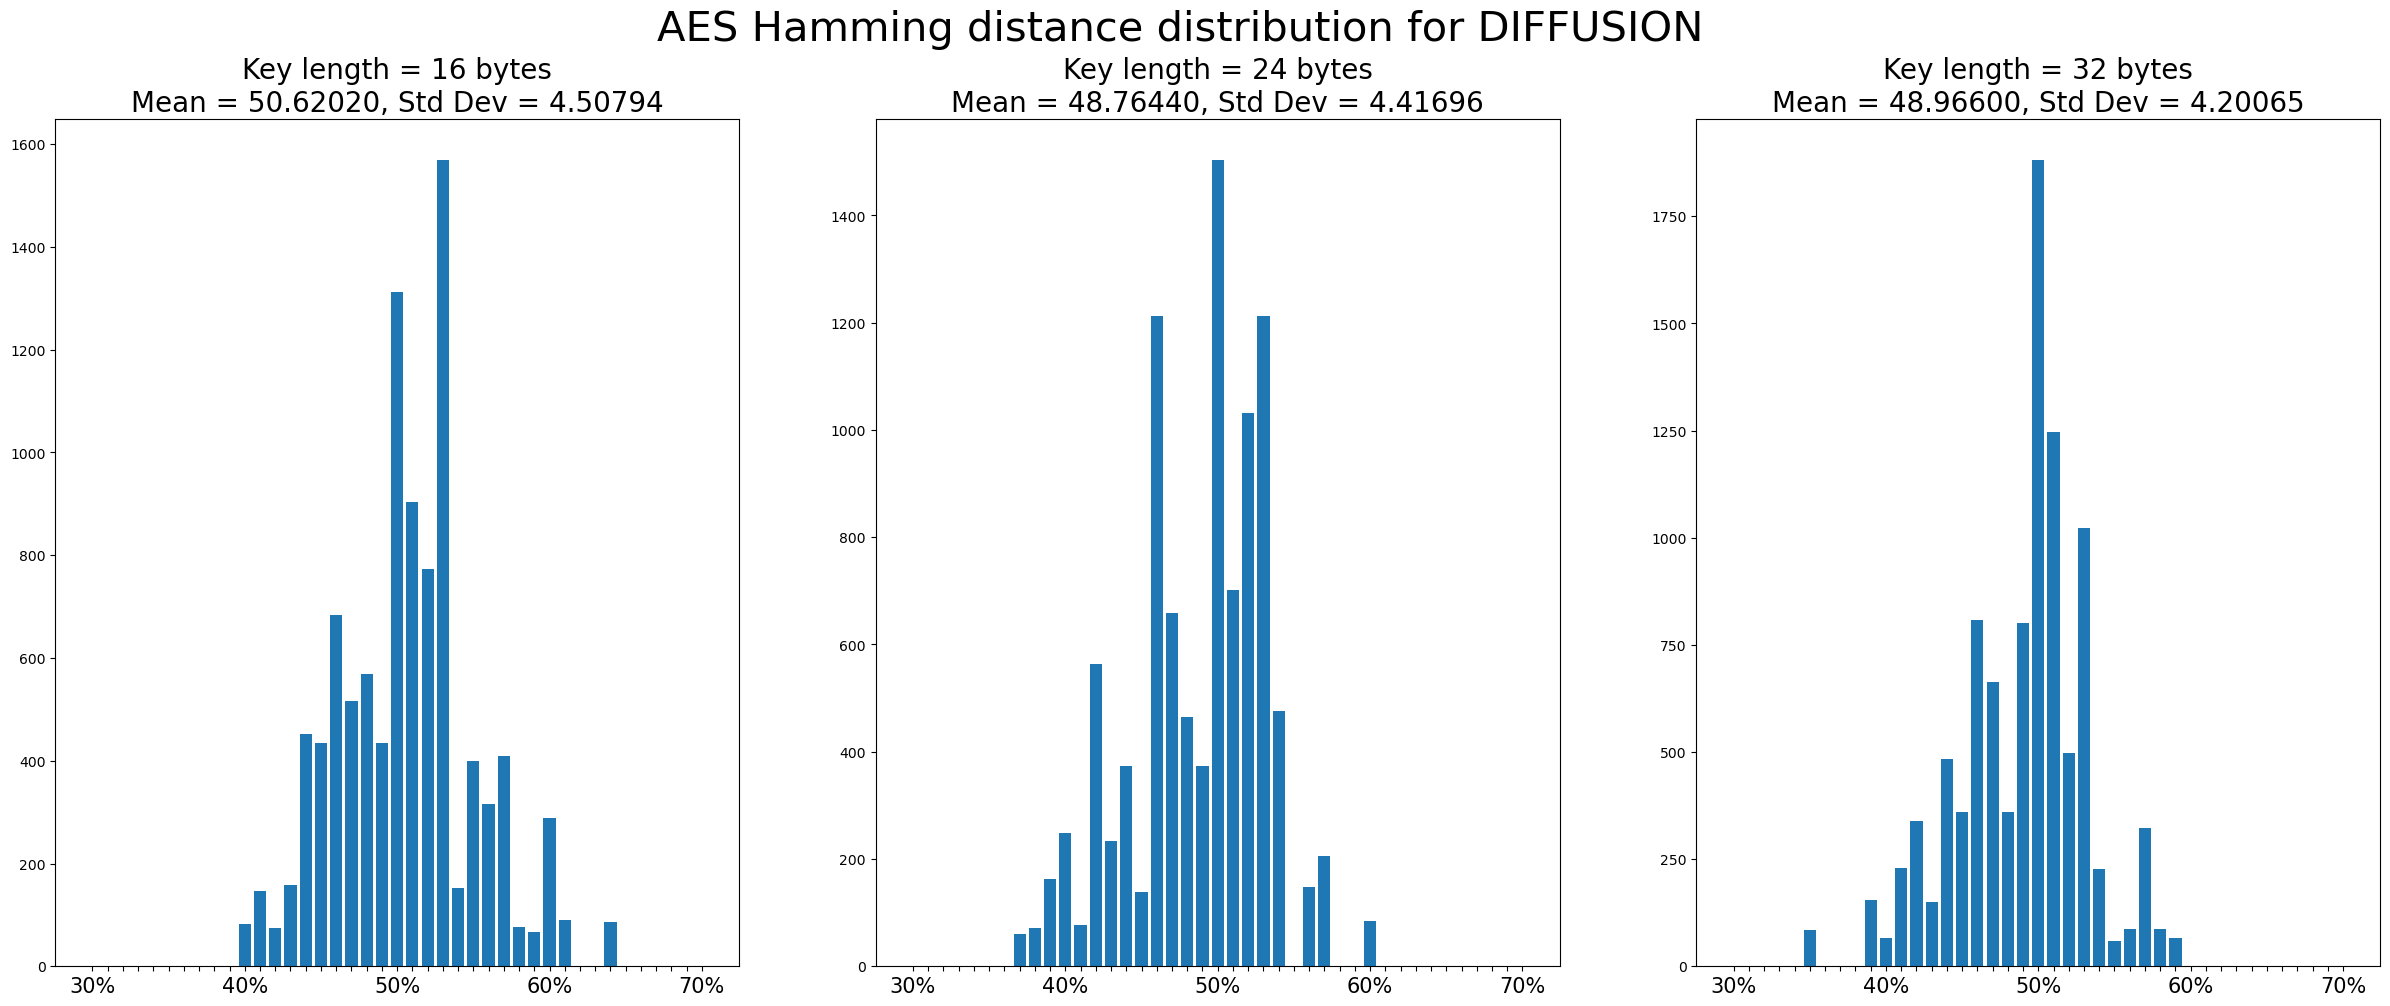

In [9]:
iterations = 10000

fig, axs = plt.subplots(1, len(AES.key_size), figsize=(30, 11))
fig.suptitle('AES Hamming distance distribution for DIFFUSION', fontsize=30)

for idx, length in enumerate(AES.key_size):
    # Generate random key of 16, 24 or 32 bytes
    key = np.random.bytes(length)
    # Instantiate AES cipher
    # ECB Mode encrypts each block independently, then any modification in the
    # ciphertext or the key is directly mapped on the ciphertext, then this is
    # the best Mode of Operation to assess diffusion and confusion
    aes_ecb = AES.new(key, AES.MODE_ECB)
    # Generate a random 16 bytes plaintext
    ref_plaintext = np.random.bytes(AES.block_size)
    # Encrypt the plaintext
    ref_ciphertext = aes_ecb.encrypt(ref_plaintext)

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the plaintext
    dist = mcs_diffusion(aes_ecb, ref_plaintext, ref_ciphertext, iterations)
    
    # Dictionary for the hamming distance distribution
    diff_dict = {i: 0 for i in range(30, 71)}

    # Count how many outcomes per percentage
    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                diff_dict[i] += 1
                break
    
    # Compute mean and standard deviation of the distribution
    mean = np.average(list(diff_dict.keys()), weights=list(diff_dict.values()))
    std = np.sqrt(np.average((list(diff_dict.keys())-mean)**2, weights=list(diff_dict.values())))

    axs[idx].bar(diff_dict.keys(), diff_dict.values())
    axs[idx].set_title(f'Key length = {length} bytes\nMean = {mean:.5f}, Std Dev = {std:.5f}', fontsize=20)
    # Show only 30%, 40%, 50%, 60%, 70% x labels
    axs[idx].set_xticks(list(diff_dict.keys()))
    axs[idx].set_xticklabels(['' if label not in [30, 40, 50, 60, 70] 
                              else f'{label}%' for label in list(diff_dict.keys())], fontsize=15)

### Confusion

The purpose of **confusion** is to hide any statistical connection between key and ciphertext. This is typically achieved with a very complicated relationship between the key and the ciphertext that should be impossible to invert. At bit level, it means that each ciphertext bit depends on many key bits. [[4]](#references)

To test if AES provides good confusion, we can apply the same Monte Carlo approach as before, but this time we should keep untouched the plaintext and modify some random bits of the key. The expected result is again to obtain a distribution centered around $\frac{L}{2}$.

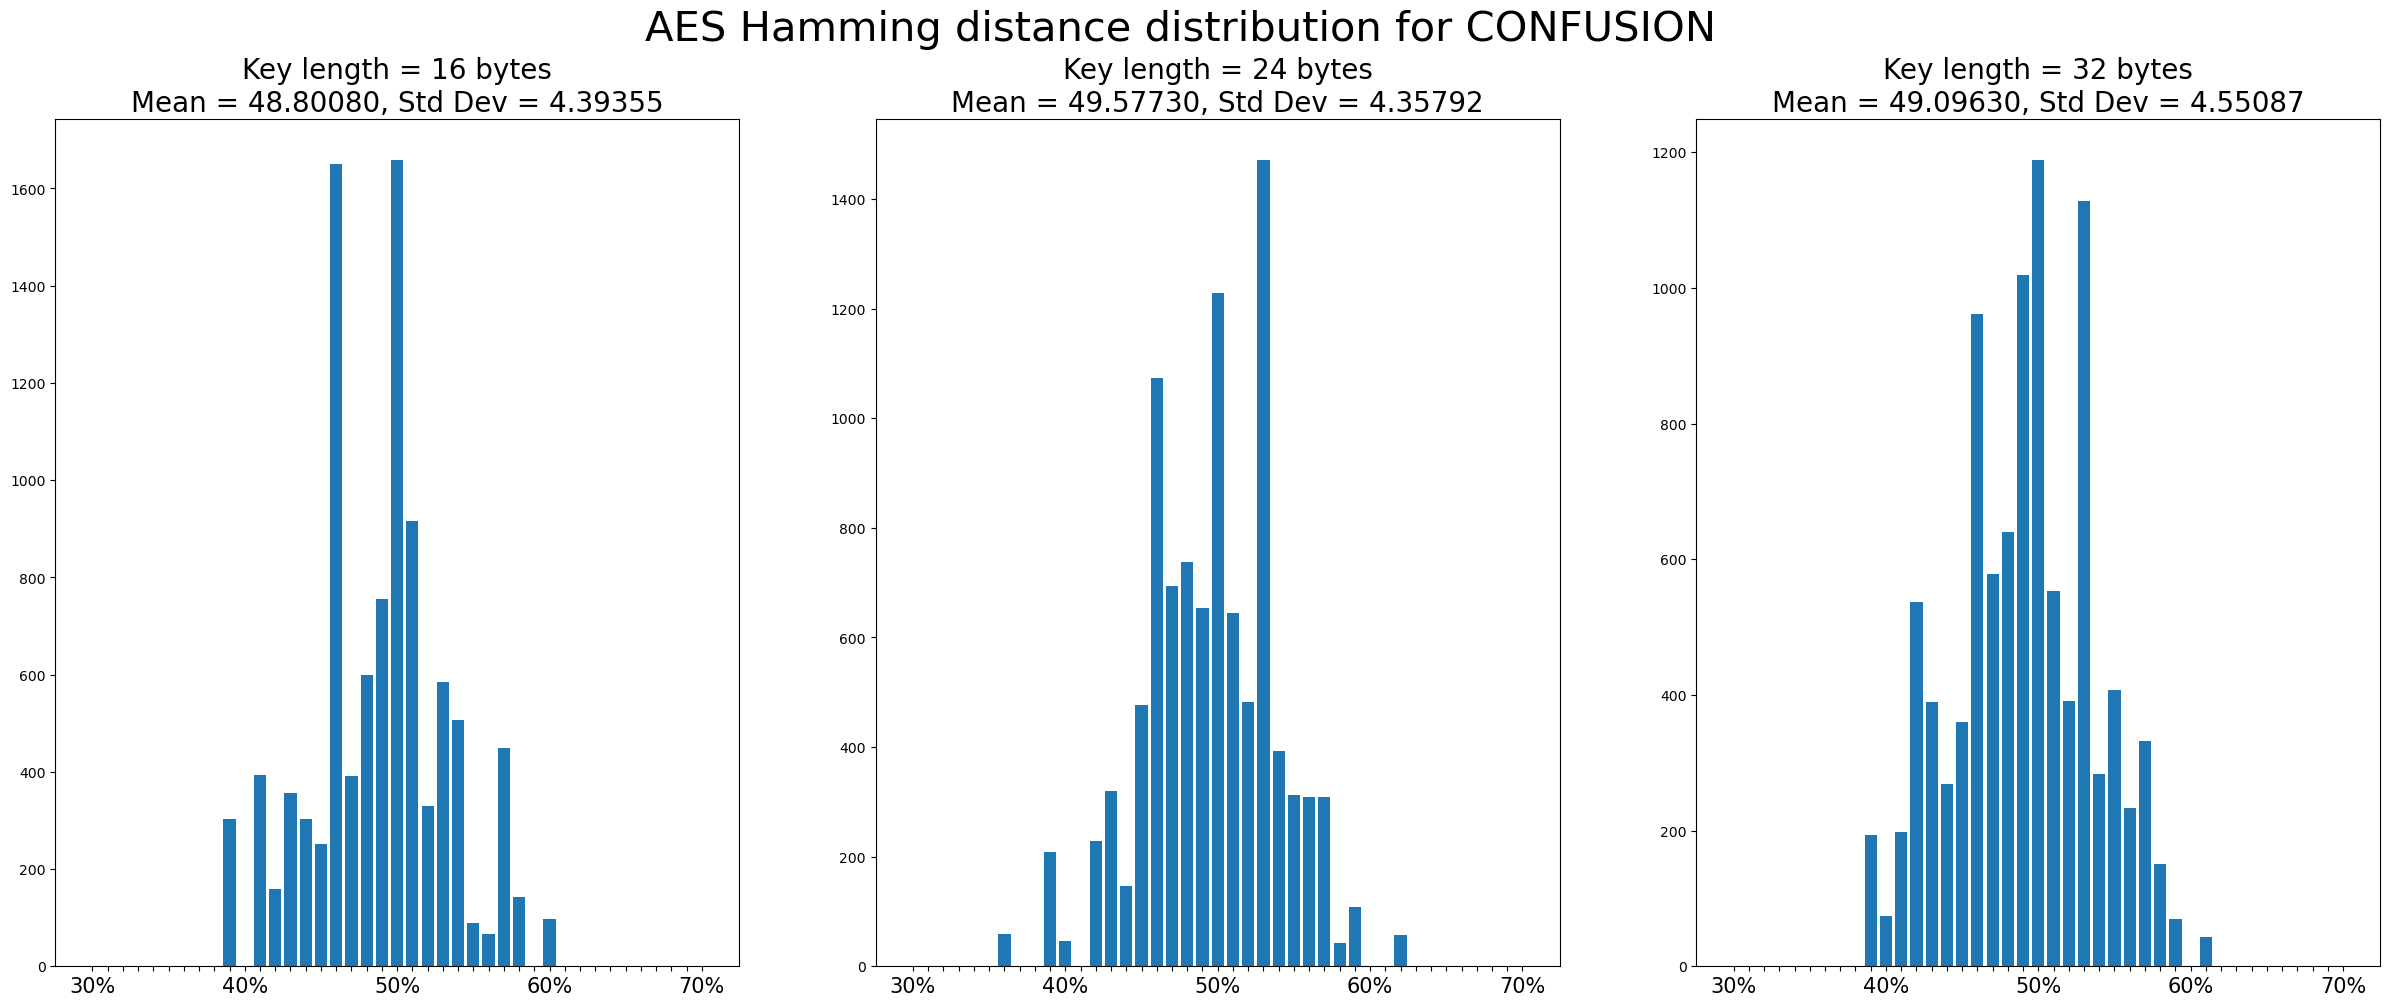

In [10]:
iterations = 10000

fig, axs = plt.subplots(1, len(AES.key_size), figsize=(30, 11))
fig.suptitle('AES Hamming distance distribution for CONFUSION', fontsize=30)

for idx, length in enumerate(AES.key_size):
    # Generate random key of 16, 24 or 32 bytes
    key = np.random.bytes(length)
    # Instantiate AES cipher
    # ECB Mode encrypts each block independently, then any modification in the
    # ciphertext or the key is directly mapped on the ciphertext, then this is
    # the best Mode of Operation to assess diffusion and confusion
    aes_ecb = AES.new(key, AES.MODE_ECB)
    # Generate a random 16 bytes plaintext
    ref_plaintext = np.random.bytes(AES.block_size)
    # Encrypt the plaintext
    ref_ciphertext = aes_ecb.encrypt(ref_plaintext)

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the key
    dist = mcs_confusion('aes', key, ref_plaintext, ref_ciphertext, iterations)
    
    # Dictionary for the hamming distance distribution
    conf_dict = {i: 0 for i in range(30, 71)}

    # Count how many outcomes per percentage
    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                conf_dict[i] += 1
                break

    # Compute mean and standard deviation of the distribution
    mean = np.average(list(conf_dict.keys()), weights=list(conf_dict.values()))
    std = np.sqrt(np.average((list(conf_dict.keys())-mean)**2, weights=list(conf_dict.values())))

    axs[idx].bar(conf_dict.keys(), conf_dict.values())
    axs[idx].set_title(f'Key length = {length} bytes\nMean = {mean:.5f}, Std Dev = {std:.5f}', fontsize=20)
    # Show only 30%, 40%, 50%, 60%, 70% x labels
    axs[idx].set_xticks(list(conf_dict.keys()))
    axs[idx].set_xticklabels(['' if label not in [30, 40, 50, 60, 70] 
                              else f'{label}%' for label in list(conf_dict.keys())], fontsize=15)

Overall, it seems that the key length has no relevant impact on the outocomes. Also, both diffusion and confusion end up having distributions centered around 50% and with similar standard deviation (the typical range goes more or less from 40% to 60%).

## RC4

**RC4 (Rivest Cipher 4)** is a stream cipher that was firstly proposed in 1987. As in typical stream ciphers, it produces a pseudorandom keystream to be XORed togehter with the plaintext and ciphertext to provide encryption and decryption. The procedure to generate the keystream follows two main phases:
- *Key-scheduling algorithm (KSA)*: this is an algorithm that produces one **permutation** of all possible 256 bytes depending on the key.
- *Pseudorandom number generation algorithm*: produces a sequence of bytes starting from the permutation, that is further modified at each iteration, and two indices, called **index pointers**. 

RC4 functioning was initially kept secret, but in 1994 it was broken and in response NIST proposed the challenge won indeed by AES.

In 2001, cryptanalysts discovered that initial bytes of the keystream were correlated to the key up to some level, allowing to obtain some information about the key. To provide a more secure cipher, **RC4-drop[n]** was introduced, where **n** specifies how many initial keystream bytes are discarded. [[5]](#references)

In [11]:
plaintext = b'hello world!'
key = b'0123456789ABCDEF'
drop = 3072

# Define two RC4s using the proper Pycryptodome class as references to test if
# our implementation is correct or not
ref_alice_RC4 = ARC4.new(key, drop)
ref_bob_RC4 = ARC4.new(key, drop)
ref_ciphertext = ref_alice_RC4.encrypt(plaintext)
ref_dec_plaintext = ref_bob_RC4.decrypt(ref_ciphertext)

# Define two RC4s using our class
alice = RC4(key, drop)
bob = RC4(key, drop)

# Execute encryption and decryption
ciphertext = alice.encrypt(plaintext)
dec_plaintext = bob.decrypt(ciphertext)

# Compare ciphertexts and plaintexts
if ref_ciphertext == ciphertext and ref_dec_plaintext == dec_plaintext:
    print('The RC4 implementation is correct!')
else:
    print('The RC4 implementation is wrong')

print(f'The ciphertext is: {ciphertext}')
print(f'The decrypted plaintext is: {dec_plaintext}')

print("\nLet's test the iterator functionality")
for n, byte_ in enumerate(alice):
    print(byte_)
    if n == 10:
        break

The RC4 implementation is correct!
The ciphertext is: b'/\x9e\xf9\x83@\x81}\xa9\xd0\xd4\xd5\xf4'
The decrypted plaintext is: b'hello world!'

Let's test the iterator functionality
b'^'
b'\x82'
b'\xb0'
b'w'
b'\xb3'
b'\xdf'
b'\xbb'
b'7'
b'~'
b'y'
b'\xa4'


### RC4 Diffusion and Confusion

We can apply the same Monte Carlo approach to evaluate diffusion and confusion for RC4.

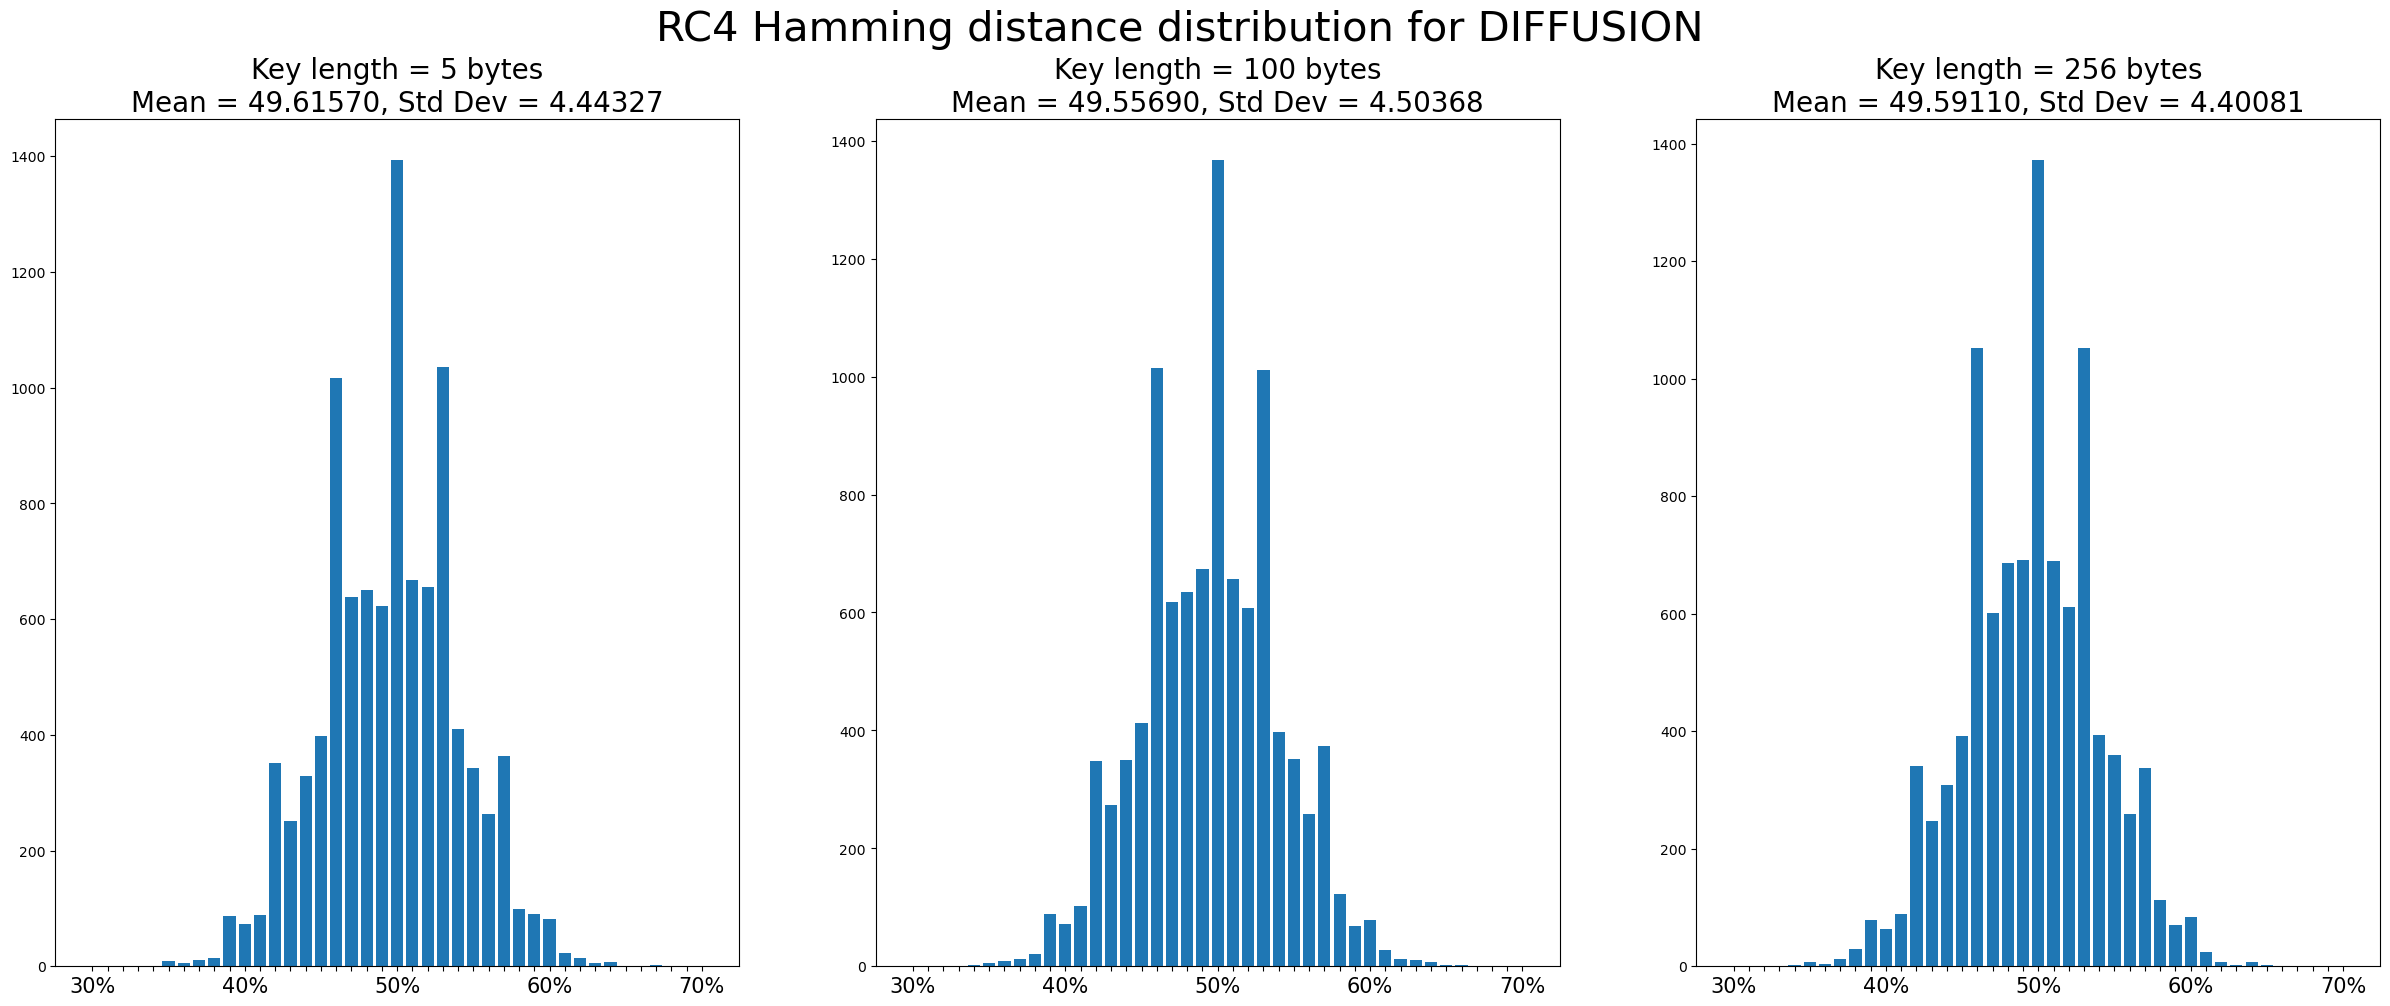

In [12]:
iterations = 10000

# Test using 3 different key lengths
RC4_key_lengths = [5, 100, 256]
drop = 3072

fig, axs = plt.subplots(1, len(RC4_key_lengths), figsize=(30, 11))
fig.suptitle('RC4 Hamming distance distribution for DIFFUSION', fontsize=30)

for idx, length in enumerate(RC4_key_lengths):
    # Generate random key of 5, 100, 256 bytes
    key = np.random.bytes(length)
    # Instantiate RC4 cipher
    rc4 = RC4(key, drop)
    # Generate a random 16 bytes plaintext
    ref_plaintext = np.random.bytes(16)
    # Encrypt the plaintext
    ref_ciphertext = rc4.encrypt(ref_plaintext)

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the plaintext
    dist = mcs_diffusion(rc4, ref_plaintext, ref_ciphertext, iterations)

    # Dictionary for the hamming distance distribution
    diff_dict = {i: 0 for i in range(30, 71)}
    
    # Count how many outcomes per percentage
    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                diff_dict[i] += 1
                break
    
    # Compute mean and standard deviation of the distribution
    mean = np.average(list(diff_dict.keys()), weights=list(diff_dict.values()))
    std = np.sqrt(np.average((list(diff_dict.keys())-mean)**2, weights=list(diff_dict.values())))
    
    axs[idx].bar(diff_dict.keys(), diff_dict.values())
    axs[idx].set_title(f'Key length = {length} bytes\nMean = {mean:.5f}, Std Dev = {std:.5f}', fontsize=20)
    # Show only 30%, 40%, 50%, 60%, 70% x labels
    axs[idx].set_xticks(list(diff_dict.keys()))
    axs[idx].set_xticklabels(['' if label not in [30, 40, 50, 60, 70] 
                              else f'{label}%' for label in list(diff_dict.keys())], fontsize=15)

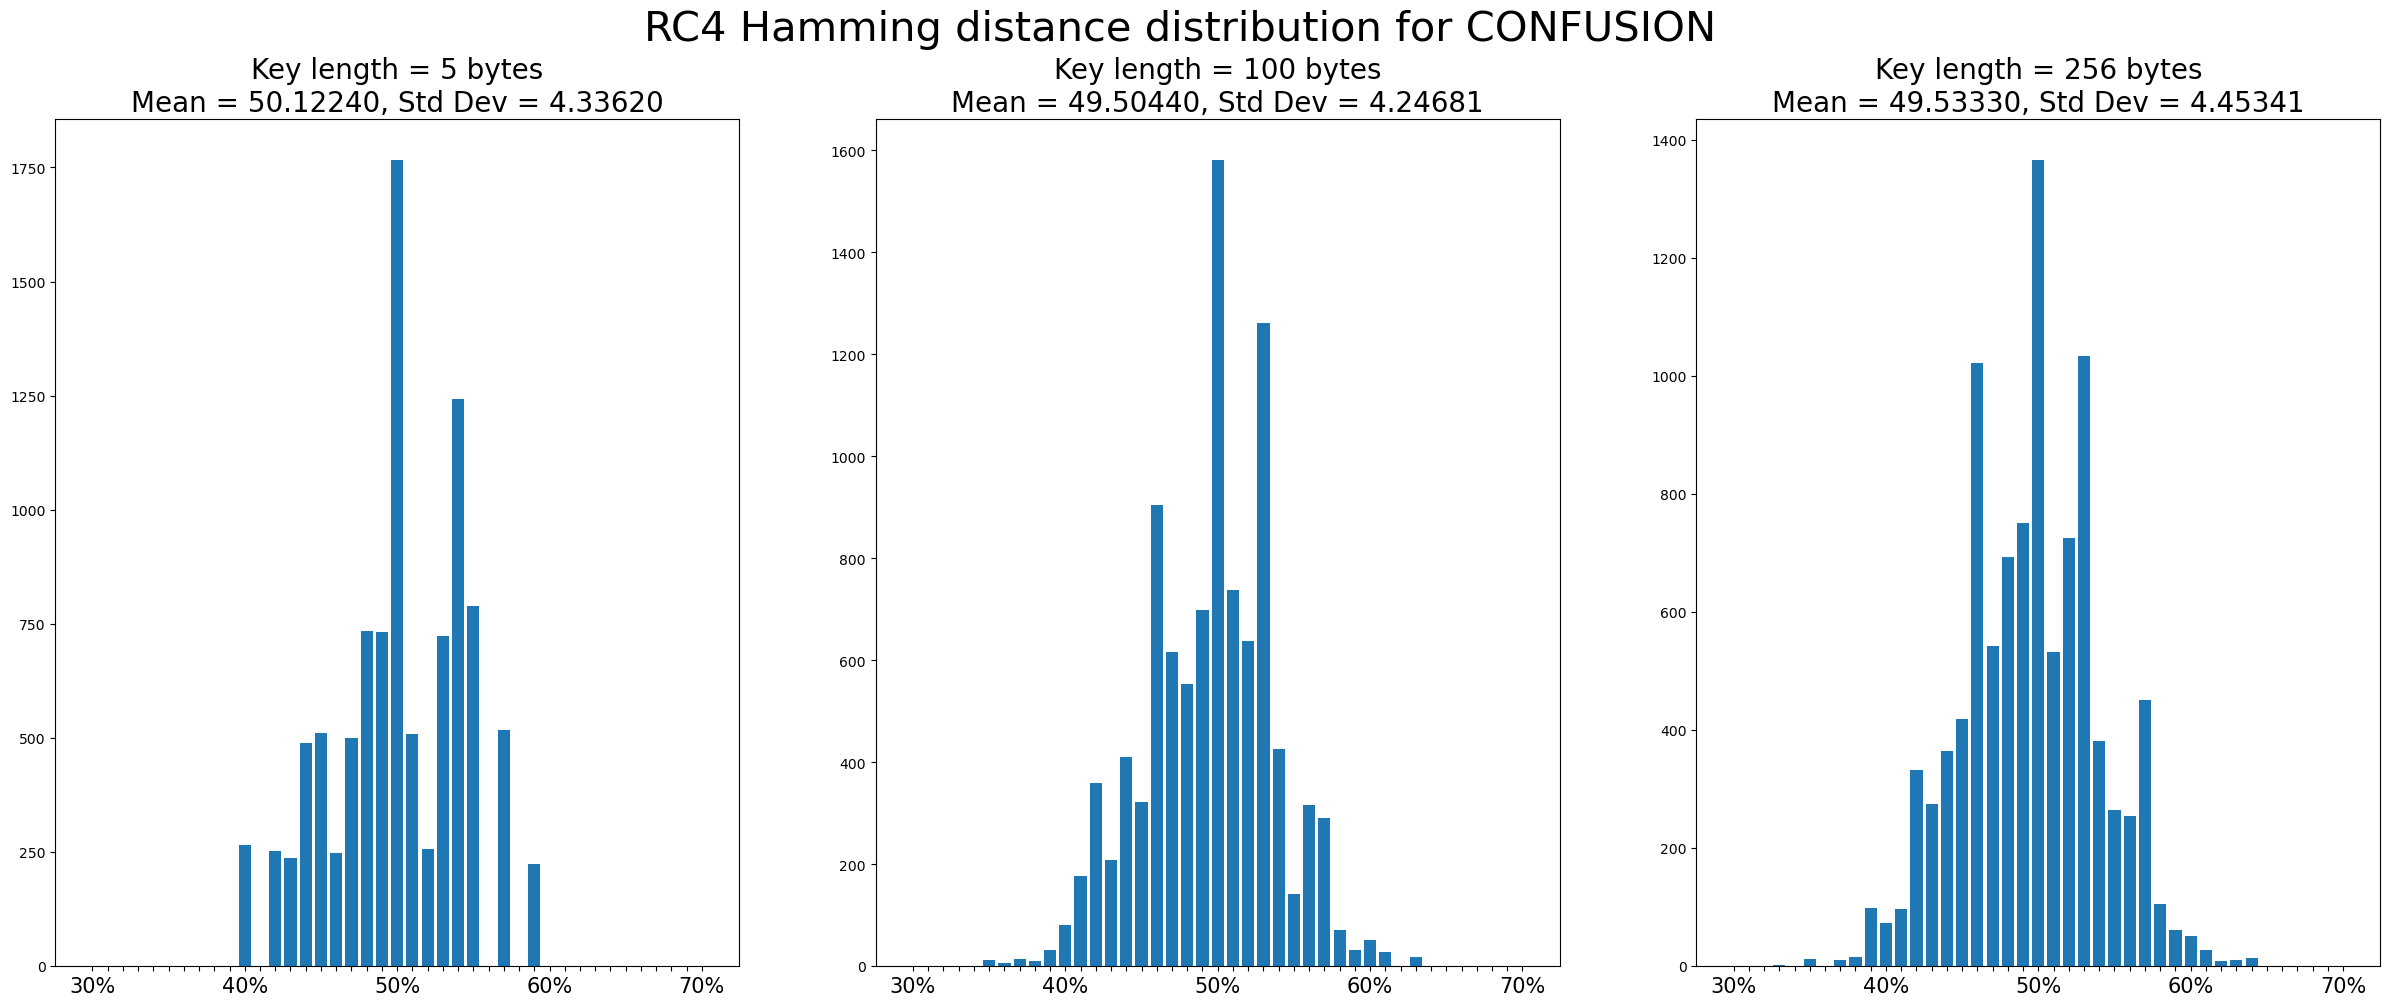

In [13]:
iterations = 10000

# Test using 3 different key lengths
RC4_key_lengths = [5, 100, 256]
drop = 768

fig, axs = plt.subplots(1, len(RC4_key_lengths), figsize=(30, 11))
fig.suptitle('RC4 Hamming distance distribution for CONFUSION', fontsize=30)

for idx, length in enumerate(RC4_key_lengths):
    # Generate random key of 5, 100, 256 bytes
    key = np.random.bytes(length)
    # Instantiate RC4 cipher
    rc4 = RC4(key, drop)
    # Generate a random 16 bytes plaintext
    ref_plaintext = np.random.bytes(16)
    # Encrypt the plaintext
    ref_ciphertext = rc4.encrypt(ref_plaintext)

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the plaintext
    dist = mcs_confusion('rc4', key, ref_plaintext, ref_ciphertext, iterations, drop)

    # Dictionary for the hamming distance distribution
    conf_dict = {i: 0 for i in range(30, 71)}

    # Count how many outcomes per percentage
    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                conf_dict[i] += 1
                break
    
    # Compute mean and standard deviation of the distribution
    mean = np.average(list(conf_dict.keys()), weights=list(conf_dict.values()))
    std = np.sqrt(np.average((list(conf_dict.keys())-mean)**2, weights=list(conf_dict.values())))

    axs[idx].bar(conf_dict.keys(), conf_dict.values())
    axs[idx].set_title(f'Key length = {length} bytes\nMean = {mean:.5f}, Std Dev = {std:.5f}', fontsize=20)
    # Show only 30%, 40%, 50%, 60%, 70% x labels
    axs[idx].set_xticks(list(conf_dict.keys()))
    axs[idx].set_xticklabels(['' if label not in [30, 40, 50, 60, 70] 
                              else f'{label}%' for label in list(conf_dict.keys())], fontsize=15)

Diffusion seems to be not particularly affected by the key length while confusion is influeced by it: in particular a lower standard deviation is typically achieved with shorter keys (such as the 5 bytes long one).

## Conclusions

In this notebook we discussed what are the main ideas behind block ciphers, then we put everything in practice using AES to encrypt an image and veryfing what level of security can be provided by different Modes of Operation. Subsequently, the Monte Carlo Method was introduced as a mean to obtain some information about a quantity that describes a phenomena or a process through a statistical approach based on the repetition of an experiment involving an initial stochastic component. We eventually proved the effectiveness of this method, initially estimating the value of $\pi$ and then evaluating the diffusion and confusion performances of AES. In the last chapter, RC4 was presented as AES predecessor and a possible implementation has been proposed and tested in terms of diffusion and confusion again with the Monte Carlo Method.

## References

[1] [Block Cipher](https://en.wikipedia.org/wiki/Block_cipher)

[2] [AES](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard)

[3] [Monte Carlo Method](https://en.wikipedia.org/wiki/Monte_Carlo_method)

[4] [Diffusion and Confusion](https://en.wikipedia.org/wiki/Confusion_and_diffusion)

[5] [RC4](https://en.wikipedia.org/wiki/RC4)